## Cityscapes Image Pairs Kaggle | Visual segmentation task using U-Net
#### Dataset and authors available here: https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs/code

#Optional: check if train/label pairs are loaded in the same order

In [ ]:
'''
import re
y = tf.data.Dataset.list_files('/content/drive/MyDrive/city_scapes/train/label/*.png',shuffle=False)
x = tf.data.Dataset.list_files('/content/drive/MyDrive/city_scapes/train/img/*.png',shuffle=False)
indx=np.array([re.findall('\d+',str(i.numpy()))[0] for i in x],dtype='int32')
indy=np.array([re.findall('\d+',str(i.numpy()))[0] for i in y],dtype='int32')
print((indx==indy).all())

y = tf.data.Dataset.list_files('/content/drive/MyDrive/city_scapes/val/label/*.png',shuffle=False)
x = tf.data.Dataset.list_files('/content/drive/MyDrive/city_scapes/val/img/*.png',shuffle=False)

indx=np.array([re.findall('\d+',str(i.numpy()))[0] for i in x],dtype='int32')
indy=np.array([re.findall('\d+',str(i.numpy()))[0] for i in y],dtype='int32')
print((indx==indy).all())
#np.array([i.numpy() for i in y],dtype='str')
'''

True
True


##### Preprocess label masks to obtain limited set of colors (corresponding to 8 different objects, including background)

In [ ]:
# Preprocessing masks to obtain pixels restrained to 8 mask object colors.
'''
import cv2
import scipy.misc
from PIL import Image
import os
fnames=os.listdir('/content/drive/MyDrive/city_scapes/val/label/')

rgb_codes={'yellow':[218,220,4],'purple':[128,63,127],'blue':[0,0,142],'gray':[70,70,70],'green':[106,142,34],'lgreen':[153, 251, 151],'pink':[243, 35, 232]}
replace_codes=[[0,255,0],[0,0,255],[255,0,0],[100,100,100],[10,70,70],[40,20,20],[200,200,200]]

rgb_color=[np.array([[i]],dtype=np.uint8) for i in rgb_codes.values()]
lab_codes=[cv2.cvtColor(i,cv2.COLOR_RGB2LAB) for i in rgb_color]
lab_codes=[lab_codes[i][0][0].tolist() for i in range(len(lab_codes))]

for i in fnames:
  mask_path="/content/drive/MyDrive/city_scapes/val/label/"+i
  image = cv2.imread(mask_path)
  result=image.copy()

  for i,k in zip(lab_codes, replace_codes):
    lab_image=cv2.cvtColor(image,cv2.COLOR_RGB2LAB)
    target_lab = i
    threshold = 20
    distance = np.sqrt(np.sum((lab_image - target_lab) ** 2, axis=2))
    mask = distance < threshold
    target_rgb = k
    result[mask] = target_rgb

  result=result.reshape((-1,3))
  remainder_ind=list(map(lambda x: ~np.isin(x,np.array(replace_codes)).all(), result))
  result[remainder_ind]=[0,0,0]
  result=result.reshape((96,256,3))
  im=Image.fromarray(result,mode="RGB")
  im.save(mask_path)
'''



##### Load the train and validation sets after preprocessing.
##### Transform label masks so that each picture is converted from 96x256x3 to 96x256, with each element in the resulting array indicating 
##### whether one of the target colors (0 through 7, with 0 being background) is present at the corresponding location.

In [1]:
import tensorflow as tf
import numpy as np

y = tf.data.Dataset.list_files('/content/drive/MyDrive/city_scapes/train/label/*.png',shuffle=False)
x = tf.data.Dataset.list_files('/content/drive/MyDrive/city_scapes/train/img/*.png',shuffle=False)
y_val = tf.data.Dataset.list_files('/content/drive/MyDrive/city_scapes/val/label/*.png',shuffle=False)
x_val = tf.data.Dataset.list_files('/content/drive/MyDrive/city_scapes/val/img/*.png',shuffle=False)
y=list(y.map(lambda y: tf.image.decode_png(tf.io.read_file(y),channels=3,dtype='uint8')))
x=list(x.map(lambda x: tf.image.decode_png(tf.io.read_file(x),channels=3,dtype='uint8')/255))
y_val=list(y_val.map(lambda y: tf.image.decode_png(tf.io.read_file(y),channels=3,dtype='uint8')))
x_val=list(x_val.map(lambda x: tf.image.decode_png(tf.io.read_file(x),channels=3,dtype='uint8')/255))

targetrgb=tf.constant([[0,0,0],[0,255,0],[0,0,255],[255,0,0],[100,100,100],[10,70,70],[40,20,20],[200,200,200]],dtype='uint8')
targetlabel=tf.constant([0,1,2,3,4,5,6,7],dtype='uint8')

def prepare_dataset(x,y):
  for loc,i in enumerate(y):
    pic=i
    list_indices=[]
    list_updates=[]
    for k,c in zip(targetrgb,targetlabel):
      logical=tf.equal(pic,k)
      logical=tf.reduce_all(logical,axis=2)
      indices=tf.where(logical)
      indices=tf.cast(indices,'int32')
      list_indices.append(indices)
      list_updates.append(tf.repeat([c],repeats=indices.shape[0],axis=0))
    list_indices=tf.concat(list_indices,axis=0)
    list_updates=tf.concat(list_updates,axis=0)

    image_arr=tf.scatter_nd(list_indices,list_updates,[96,256])
    image_arr=tf.one_hot(image_arr,depth=len(targetlabel),dtype='uint8')
    y[loc]=image_arr

  df=tf.data.Dataset.from_tensor_slices((x,y))
  return df

train_dataset=prepare_dataset(x,y)
val_dataset=prepare_dataset(x_val,y_val)

#label_preprocessed_df=tf.data.Dataset.from_tensor_slices(y)
#label_preprocessed_df.save('/content/drive/MyDrive/')


#### Define the model, prepare both datasets and fit the model

In [2]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import os

def unet(input_size=(96, 256, 3)):

    inputs=tf.keras.layers.Input(shape=input_size)
    downscale1=tf.keras.layers.Conv2D(64,(3,3),strides=(1,1),activation='relu',padding='same') (inputs)
    downscale2=tf.keras.layers.Conv2D(64,(3,3),strides=(1,1),activation='relu',padding='same')(downscale1)
    maxpool_d1=tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid') (downscale2)

    downscale3=tf.keras.layers.Conv2D(128,(3,3),strides=(1,1),activation='relu',padding='same') (maxpool_d1)
    downscale4=tf.keras.layers.Conv2D(128,(3,3),strides=(1,1),activation='relu',padding='same') (downscale3)
    maxpool_d2=tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid') (downscale4)

    downscale5=tf.keras.layers.Conv2D(256,(3,3),strides=(1,1),activation='relu',padding='same') (maxpool_d2)
    downscale6=tf.keras.layers.Conv2D(256,(3,3),strides=(1,1),activation='relu',padding='same') (downscale5)
    maxpool_d3=tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid') (downscale6)

    downscale7=tf.keras.layers.Conv2D(512,(3,3),strides=(1,1),activation='relu',padding='same') (maxpool_d3)
    downscale8=tf.keras.layers.Conv2D(512,(3,3),strides=(1,1),activation='relu',padding='same') (downscale7)
    maxpool_d4=tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid') (downscale8)

    downscale9=tf.keras.layers.Conv2D(1024,(3,3),strides=(1,1),activation='relu',padding='same') (maxpool_d4)
    downscale10=tf.keras.layers.Conv2D(1024,(3,3),strides=(1,1),activation='relu',padding='same') (downscale9)

    upscale1 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='valid')(downscale10)
    upscale1  = tf.keras.layers.concatenate([upscale1, downscale8])
    convup1 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(upscale1)
    convup2 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(convup1)

    upscale2 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='valid')(convup2)
    upscale2 = tf.keras.layers.concatenate([upscale2, downscale6])
    convup3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(upscale2)
    convup4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(convup3)

    upscale8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='valid')(convup4)
    upscale8 = tf.keras.layers.concatenate([upscale8, downscale4])
    convup8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(upscale8)
    convup9 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(convup8)

    upscale9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='valid')(convup9)
    upscale9 = tf.keras.layers.concatenate([upscale9, downscale2])
    convup9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(upscale9)
    convup10 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(convup9)

    outputs = tf.keras.layers.Conv2D(8, (1, 1), activation='softmax')(convup10)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


unet = unet()
unet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


train_dataset = train_dataset
val_dataset = val_dataset


def prepare_dataset(dataset, batch_size=16, cache_file=".cache"):
    return (dataset
            .cache(cache_file)
            .shuffle(1000)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE))

train_dataset = prepare_dataset(train_dataset)
val_dataset = prepare_dataset(val_dataset)


checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)



unet.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[checkpoint_callback]
)


Epoch 1/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.3157 - loss: 1.7009
Epoch 1: val_loss improved from inf to 1.02724, saving model to best_model.keras
186/186 ━━━━━━━━━━━━━━━━━━━━ 53s 146ms/step - accuracy: 0.3163 - loss: 1.6994 - val_accuracy: 0.6205 - val_loss: 1.0272
Epoch 2/50
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6522 - loss: 0.9367
Epoch 2: val_loss improved from 1.02724 to 0.80707, saving model to best_model.keras
186/186 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.6524 - loss: 0.9360 - val_accuracy: 0.7072 - val_loss: 0.8071
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7104 - loss: 0.7784
Epoch 3: val_loss improved from 0.80707 to 0.70601, saving model to best_model.keras
186/186 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.7105 - loss: 0.7782 - val_accuracy: 0.7325 - val_loss: 0.7060
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7506 - loss: 0.6659
Epoch 4: val_loss improved from 0.70601 to

#### Miscellaneous part further

In [ ]:
from sklearn.cluster import DBSCAN
from skimage import color
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

#### Have a glance at the processed masks

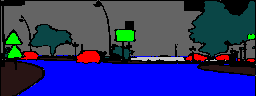

In [ ]:
mask_path="/content/drive/MyDrive/city_scapes/train/label/train1.png"
mask = Image.open(mask_path).convert("RGB")
mask

#### Display colors in the original (not preprocessed) mask labels as a color spectre

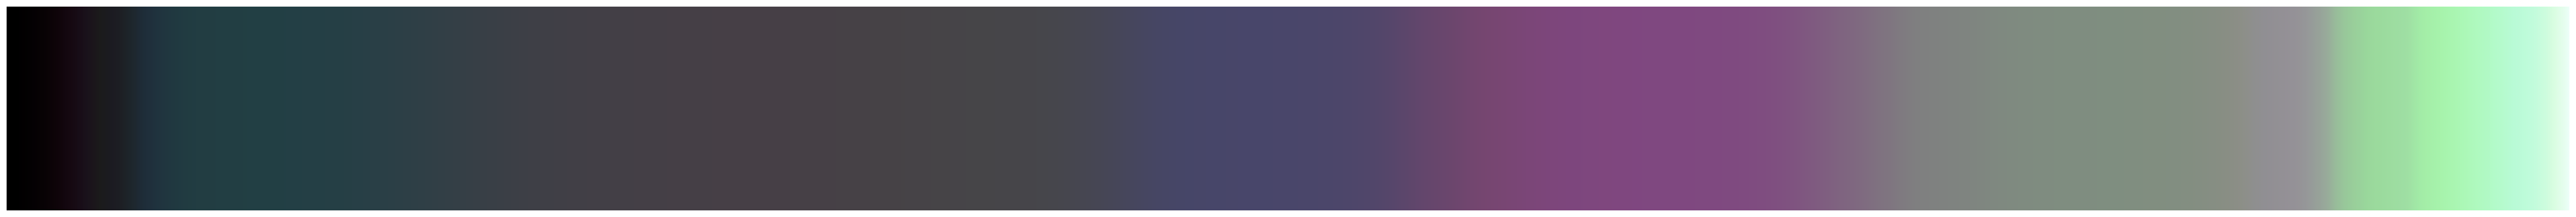

In [ ]:
'''
uniques, counts=np.unique(cluster_colors,axis=0,return_counts=True)
height=1
width=cluster_colors.shape[0]
color_palette = cluster_colors.reshape((height, width, 3))

plt.rcParams['figure.figsize'] = [50, 4]
# Display the color palette
plt.imshow(np.sort(color_palette,axis=1), aspect='auto')
plt.axis('off')  # Hide axes
plt.show()
'''

#### Example of the original label mask

In [ ]:
#!pip install Pylette
import Pylette as pyt

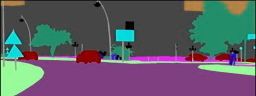

In [ ]:
mask

#### Some RGB codes from the original labels (mostly varying for same colors)

In [ ]:
"""
dark gray: [68, 70, 69], [69, 69, 70], [68, 70, 69], [69, 70, 70], [69, 69, 69], [70, 70, 70]
purple: [126, 63, 127], [[127,  62, 127]], [127,  62, 127], [127,  63, 127], [128,  62, 127]
dark green: [ 38, 138, 106], [ 40, 139, 107], [ 39, 139, 106], [ 39, 138, 106], [ 41, 139, 108]
lime: [155, 245, 157], [167, 231, 165], [162, 239, 163], [169, 221, 173], [154, 244, 159]
red: [129, 6, 13], [132,   7,  12], [137,   1,   2], [136,   2,   3], [135,   3,   7]
black: [22, 29, 25], [17,15,17], [12,14,12], [32,27,29], [18,18,18], [25,22,24]
dark red: [107,  42,  46],

"""

#### A function to compute Euclidean distance

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def ecld(x,y,threshold=25):
  try:
    x=np.asarray(x).reshape((-1,3))
    y=np.asarray(y).reshape((-1,3))

  except ValueError:
    return 'Incompatible dimensions'
  if len(x)!=len(y):
    if len(x)<len(y):
      x=np.repeat(x,len(y),axis=0)
      sqdifference=np.sqrt(np.sum(np.square(y-x),axis=1))
      indices=np.where(sqdifference<threshold)
      return (sqdifference,indices)

    else:
      y=np.repeat(y,len(x),axis=0)
      sqdifference=np.sqrt(np.sum(np.square(x-y),axis=1))
      indices=np.where(sqdifference<threshold)
      return indices

  x=np.repeat(x,len(y),axis=0)
  sqdifference=np.sqrt(np.sum(np.square(y-x),axis=1))
  indices=np.where(sqdifference<threshold)
  return (sqdifference,indices)

'\naveraged_colors=[]\niteration=colorset.copy()\nunclassified=0\n\nfor i in iteration:\n  if i not in colorset or len(colorset)==0:\n    continue\n\n  ind=ecld(i,colorset, threshold=16)\n  print(ind)\n  if len(ind[0])==0:\n    continue\n\n  color_avg=np.average(colorset[ind[0]],axis=0)\n  color_avg=np.asarray(list(map(int,color_avg))).reshape((-1,3))\n  averaged_colors.append(color_avg)\n  colorset=np.delete(colorset,ind,axis=0)\n#for i in colorset[ind]:\n#  temp=np.asarray([[i]])\n#  print(temp)\n#  plt.imshow(temp)\n#  plt.show()\n\naveraged_colors=np.stack(averaged_colors)\n'